# Test implementation of the TDA approach for model selection

Using methods from TDA we want to implement the following pipline for assessing model selection:

1. Use the cubical homology to create a set of persistence diagrams from both the ideal case (just the data and labels), and the features post model inference with the labels.
2. Given each set of persistence diagrams create a persistance image - essentially a vector representation of topological information.
3. Compare the (Euclidean) distance between the vector for each model and the vector for the base case, with the shorter the distance suggesting better performance post fine tuning of a model.

This can be done using the giotto-ai library.

In [1]:
from typing import Callable, Iterable

import numpy as np

np.set_printoptions(edgeitems=30, linewidth=180)

from copy import copy

import requests
import torch
from datasets import Dataset, load_dataset
from numpy.typing import ArrayLike
from PIL import Image
from scipy.stats import spearmanr
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, pipeline

## Import the data and models

In [73]:
model_name = "google/vit-base-patch16-224"
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=0)
classifier = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [66]:
dataset = load_dataset("imagenet-1k", split="validation", token=True, streaming=True)

In [80]:
def iter_extr(iterable, idx_c=0):
    for idx, iter in enumerate(iterable):
        if idx == idx_c:
            return iter

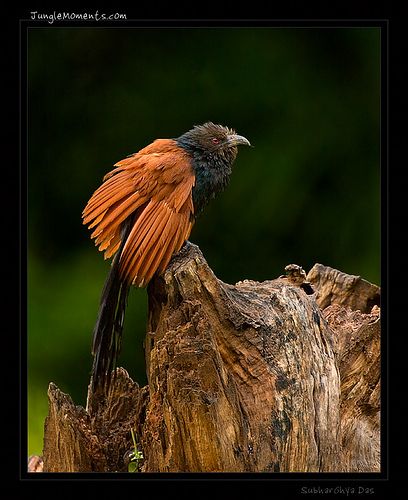

In [5]:
display(next(iter(dataset))["image"])

In [75]:
# Preprocess for the use in the models


def preprocess(examples):
    examples["pixel_values"] = [
        processor(image.convert("RGB"))["pixel_values"][0]
        for image in examples["image"]
    ]
    return examples


imgs = dataset.map(preprocess, remove_columns="image", batched=True, batch_size=1)
imgs = imgs.with_format("torch")

In [85]:
feat1 = model(next(iter(imgs))["pixel_values"][None, :, :, :]).logits
feat2 = model(iter_extr(imgs, 1)["pixel_values"][None, :, :, :]).logits
print(f"the shapes here are {feat1.shape} and {feat2.shape}")
joint = np.concatenate((feat1.detach().numpy(), feat2.detach().numpy()), axis=0)
print(f"the shape of the join is: {joint.shape}")

the shapes here are torch.Size([1, 768]) and torch.Size([1, 768])
the shape of the join is: (2, 768)


In [314]:
classifier(next(iter(imgs))["pixel_values"][None, :, :, :]).logits.argmax(-1).item()

91

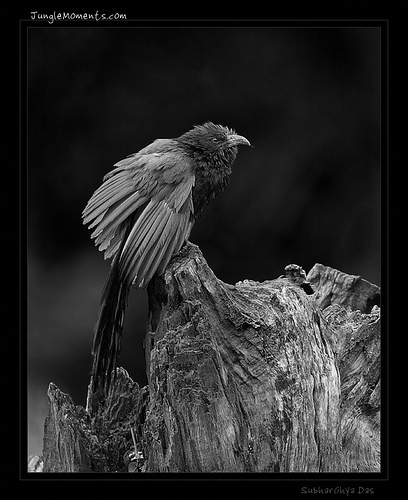

In [6]:
# TDA method requires Grayscale
from torchvision.transforms import Grayscale

display(Grayscale()(next(iter(dataset))["image"]))

To get this to work all of the images have to be the same size, hence resizing them to 224 x 224 pixels

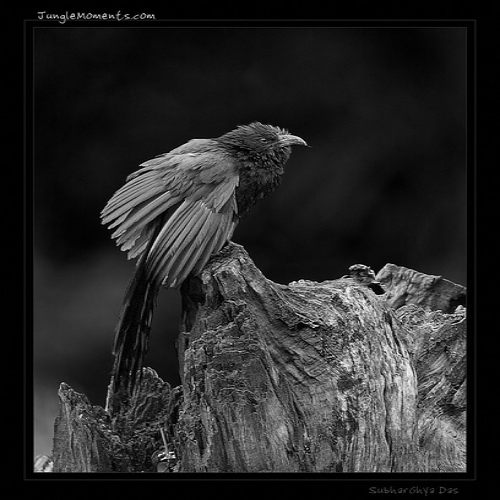

In [152]:
from torchvision.transforms import Resize

display(Resize((500, 500))(Grayscale()(next(iter(dataset))["image"])))

In [19]:
from torchvision.transforms import ToTensor

T = ToTensor()(Resize((224, 224))(Grayscale()(next(iter(dataset))["image"])))
T.shape

torch.Size([1, 224, 224])

In [20]:
pixels = 224
num_labels = None
if num_labels is not None:
    pixels = num_labels


def tda_preprocess(examples):
    examples["pixel_values"] = [
        ToTensor()(Resize((pixels, pixels))(Grayscale()(image)))
        for image in examples["image"]
    ]
    return examples


tda_imgs = dataset.map(
    tda_preprocess, remove_columns="image", batched=True, batch_size=1
)
tda_imgs = tda_imgs.with_format("torch")

In [15]:
next(iter(tda_imgs))["pixel_values"].shape

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


torch.Size([1, 224, 224])

Tom's reccommendation is to feed the homology object (diagram maker) (n,d) tensors of n data points where the each row either:

- (x_1, ..., x_n, y) OR
- (x_1, ..., x_n, f(x))

where x are the flattened pixel values of the original images, y is the ground truth label (typically just the integer is passed, but might be worth trying this with the one hot vectors instead) and f(x) are the features.

## TDA

Replacing the cubical homology method with the Vietoris Rips homology methd. This allows for images of different sizes, but according to Tom is incredibly slow to process...

The idea here being that I give it p (m, n+f_p) lists of m example arrays of (x_1, ..., x_n, f(x)) where x are the flattened pixel values from the images, f_p(x) is either the ground truth labels or the model labels/features (either should work).

In [16]:
from gtda import diagrams
from gtda import homology as hom
from sklearn.preprocessing import OneHotEncoder
from torch import Tensor, cat, flatten, reshape

In [17]:
def pad_and_wrap_one_hot(one_hot, pix_val=224):
    """If the one hot vector is less than 224 in dimension then pad it to 224. If
    greater than pad it to a multiple of 224 then wrap it.
    """
    if one_hot.shape[0] % pix_val == 0:
        return one_hot
    else:
        pad_vec = np.concatenate(
            (one_hot, np.zeros(pix_val - (one_hot.shape[0] % pix_val)))
        )
        pad_vec = pad_vec.reshape(1, pad_vec.shape[0] // pix_val, pix_val)
        return pad_vec


def one_tda_example(img, label, one_hot=False):
    if one_hot:
        return np.concatenate(
            (np.asarray(img), pad_and_wrap_one_hot(label, img.shape[2])), axis=1
        )
    else:
        return np.concatenate(
            (np.asarray(img), np.full((1, 1, img.shape[1]), label)), axis=1
        )


def tda_probe_set_labs(n: int, img_iter: Iterable, one_hot=False):
    """Create a probe set of representations for use in a TDA pipelin with the ground
    truth labels.

    Args:
        - n (int): size of the probe set
        - img_iter: iterable dataset for TDA
    """
    # Work around for the one hot labels because I'm streaming the data here.
    if one_hot:
        labels = np.zeros(n)
        for idx, label in enumerate(img_iter):
            labels[idx] = label["label"]
            if idx == n - 1:
                break
        labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))

    examples = []
    for idx, image in enumerate(img_iter):
        if one_hot:
            label = labels[idx]
        else:
            label = image["label"]
        examples.append(one_tda_example(image["pixel_values"], label, one_hot))
        if idx == n - 1:
            break
    return np.concatenate(examples, axis=0)

In [21]:
probe_set_labs = tda_probe_set_labs(10, tda_imgs, one_hot=True)
probe_set_labs.shape

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


(10, 225, 224)

The cubical homlogy requires a 2D array of pixel values for a grayscale image. 

In [22]:
cub_hom = hom.CubicalPersistence([0, 1])

In [23]:
diag = cub_hom.fit_transform(probe_set_labs)

In [38]:
np.unique(diag[2, :, 2], return_counts=True)[1]

array([3641, 5242])

In [292]:
from gtda.plotting import plot_diagram

plot_diagram(diag[0])

In [293]:
diag.shape

(10, 8883, 3)

Now make some diagrams with features from the above model.

### Persistance images

From the diagrams make the persistance images. Initially just for the one.

In [295]:
per_img = diags.PersistenceImage()

In [296]:
img = per_img.fit_transform(diag)

In [297]:
img.shape

(10, 2, 100, 100)

In [298]:
per_img.fit_transform_plot(diag)

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000

Need to make sure the bounding boxes are the same size. Make the persistance diagram for all them.

## Questions:

1. Features or labels?

one hot wrap around technique:

In [137]:
vec = np.zeros(1000)
vec[220] = 1.0

In [128]:
vec.shape[0] % 224

221

In [129]:
if vec.shape[0] % 224 != 0:
    pad_vec = np.concatenate((vec, np.zeros(224 - (vec.shape[0] % 224))))

In [113]:
pad_vec = np.concatenate((vec, np.zeros(224 - (vec.shape[0] % 224))))

In [134]:
pad_vec.reshape(1, pad_vec.shape[0] // 224, 224).shape

(1, 1, 224)

In [201]:
def pad_and_wrap_one_hot(one_hot, pix_val=224):
    """If the one hot vector is less than 224 in dimension then pad it to 224. If
    greater than pad it to a multiple of 224 then wrap it.
    """
    if one_hot.shape[0] % pix_val == 0:
        return one_hot
    else:
        pad_vec = np.concatenate(
            (one_hot, np.zeros(pix_val - (one_hot.shape[0] % pix_val)))
        )
        pad_vec = pad_vec.reshape(1, pad_vec.shape[0] // pix_val, pix_val)
        return pad_vec

In [200]:
ohv = np.zeros(512)
ohv[351] = 1.0
phv = np.concatenate((ohv, np.zeros(224 - (ohv.shape[0] % 224))))
print(phv.shape)
phv = phv.reshape(1, phv.shape[0] // 224, 224)
phv.shape

(672,)


(1, 3, 224)

In [190]:
pad_and_wrap_one_hot(ohv)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [138]:
pad_and_wrap_one_hot(vec)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Putting it together

Write full version with hyperparemeter choices:

1. Adjust pixel size for num_classes.
2. One hot vs class label.

If (1) is False and (2) is one hot then use wrap around for the vector, else just pad the class label as discussed above.

In [ ]:
def pad_and_wrap_one_hot(one_hot, pix_val=224):
    """If the one hot vector is less than 224 in dimension then pad it to 224. If
    greater than pad it to a multiple of 224 then wrap it.
    """
    if one_hot.shape[0] % pix_val == 0:
        return one_hot
    else:
        pad_vec = np.concatenate(
            (one_hot, np.zeros(pix_val - (one_hot.shape[0] % pix_val)))
        )
        pad_vec = pad_vec.reshape(1, pad_vec.shape[0] // pix_val, pix_val)
        return pad_vec


def one_tda_example(img, label, one_hot=False):
    if one_hot:
        return np.concatenate(
            (np.asarray(img), pad_and_wrap_one_hot(label, img.shape[2])), axis=1
        )
    else:
        return np.concatenate(
            (np.asarray(img), np.full((1, 1, img.shape[1]), label)), axis=1
        )


def tda_probe_set_labs(n: int, img_iter: Iterable, one_hot=False):
    """Create a probe set of representations for use in a TDA pipelin with the ground
    truth labels.

    Args:
        - n (int): size of the probe set
        - img_iter: iterable dataset for TDA
    """
    # Work around for the one hot labels because I'm streaming the data here.
    if one_hot:
        labels = np.zeros(n)
        for idx, label in enumerate(img_iter):
            labels[idx] = label["label"]
            if idx == n - 1:
                break
        labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))

    examples = []
    for idx, image in enumerate(img_iter):
        if one_hot:
            label = labels[idx]
        else:
            label = image["label"]
        examples.append(one_tda_example(image["pixel_values"], label, one_hot))
        if idx == n - 1:
            break
    return np.concatenate(examples, axis=0)

In [337]:
def tda_probe_set_preds(
    n: int,
    tda_img_iter: Iterable,
    inf_img_iter: Iterable,
    classifier,
    one_hot=False,
):
    """Create a probe set of representations for use in a TDA pipelin with the ground
    truth labels.

    Args:
        - n (int): size of the probe set
        - tda_img_iter: iterable dataset for TDA
        - inf_img_iter: iterable dataset for inference
        - one_hot: use one hot encoding or just integer labesl
    """
    # Work around for collecting predicted classes as streaming data
    preds = np.zeros(n)
    for idx, image in enumerate(inf_img_iter):
        preds[idx] = (
            classifier(image["pixel_values"][None, :, :, :]).logits.argmax(-1).item()
        )
        if idx == n - 1:
            break

    if one_hot:
        preds = OneHotEncoder(sparse_output=False).fit_transform(preds.reshape(-1, 1))

    examples = []
    for idx, image in enumerate(tda_img_iter):
        examples.append(one_tda_example(image["pixel_values"], preds[idx], one_hot))
        if idx == n - 1:
            break
    return np.concatenate(examples, axis=0)

In [338]:
preds_examples = tda_probe_set_preds(10, tda_imgs, imgs, classifier, one_hot=True)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [343]:
def tda_pipeline(tda_examples_set):
    cub_hom = hom.CubicalPersistence([0, 1])
    return cub_hom.fit_transform(tda_examples_set)
    # print(diags.shape)
    # per_img = diagrams.PersistenceImage()
    # return per_img.fit_transform(diags)

In [344]:
preds_diags = tda_pipeline(preds_examples)

In [345]:
preds_diags.shape

(10, 8883, 3)

In [346]:
labs_examples = tda_probe_set_labs(10, tda_imgs, one_hot=True)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [347]:
labs_diags = tda_pipeline(labs_examples)

In [348]:
labs_diags.shape

(10, 8883, 3)

In [354]:
per_img = diagrams.PersistenceImage()
all_imgs = per_img.fit_transform(np.concatenate((labs_diags, preds_diags), axis=0))

In [355]:
np.linalg.norm(all_imgs[:10, :, :, :] - all_imgs[10:, :, :, :])

298.2457145488734

## An Attempt at a full experiment pipeline for the purpose of running experiments....

In [2]:
from typing import Iterable

import numpy as np
from datasets import Dataset, load_dataset
from gtda import diagrams as dgms
from gtda import homology as hom
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from torch import Tensor, cat, flatten, reshape
from torchvision.transforms import Grayscale, Resize, ToTensor
from transformers import AutoImageProcessor, AutoModelForImageClassification

# from tdqm import tdqm
np.set_printoptions(edgeitems=30, linewidth=180)


def feature_reduce(features: np.ndarray, random_state: int, f: int = 32) -> np.ndarray:
    """Use PCA to reduce the dimensionality of features.

    Args:
        features: features on which to reduce.
        f: dimension to reduce down to.

    Returns:
        Reduced features array.
    """
    if f is None:
        return features

    if f > min(features.shape):
        raise ValueError(
            "Reduced dimension should not be more than minimum features dimension."
        )

    return PCA(
        n_components=f,
        svd_solver="randomized",
        iterated_power=1,
        random_state=random_state,
    ).fit_transform(features)


def pad_and_wrap_one_hot(one_hot, pix_val=224):
    """If the one hot vector is less than 224 in dimension then pad it to 224. If
    greater than pad it to a multiple of 224 then wrap it.
    """
    if one_hot.shape[0] % pix_val == 0:
        return one_hot
    else:
        pad_vec = np.concatenate(
            (one_hot, np.zeros(pix_val - (one_hot.shape[0] % pix_val)))
        )
        pad_vec = pad_vec.reshape(1, pad_vec.shape[0] // pix_val, pix_val)
        return pad_vec


def one_tda_example(
    img,
    model_output,
    one_hot=False,
    model_features=False,
    random_state=42,
    pixels_side=224,
):
    if model_features:
        # print('computing one tda example feature for model features not labels')
        return np.concatenate(
            (img.detach().numpy(), model_output.reshape(1, 1, pixels_side)), axis=1
        )
    if one_hot:
        # print('computing one tda example feature for one hot labels not features')
        return np.concatenate(
            (img.detach().numpy(), pad_and_wrap_one_hot(model_output, img.shape[2])),
            axis=1,
        )
    # print('computing one tda example feature for integers labels not features')
    return np.concatenate(
        (img.detach().numpy(), np.full((1, 1, img.shape[1]), model_output)), axis=1
    )


def tda_preprocess(examples, pixels=224):
    examples["pixel_values"] = [
        ToTensor()(Resize((pixels, pixels))(Grayscale()(image)))
        for image in examples["image"]
    ]
    return examples


# This should be one function with the other version in the script...


def tda_probe_set_labs(n: int, tda_img_iter: Iterable, one_hot=False):
    """Create a probe set of representations for use in a TDA pipelin with the ground
    truth labels.

    Args:
        - n (int): size of the probe set
        - img_iter: iterable dataset for TDA
    """
    # Work around for the one hot labels because I'm streaming the data here.
    if one_hot:
        labels = np.zeros(n)
        for idx, label in enumerate(tda_img_iter):
            labels[idx] = label["label"]
            if idx == n - 1:
                break
        labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))

    examples = []
    for idx, image in enumerate(tda_img_iter):
        if one_hot:
            label = labels[idx]
        else:
            label = image["label"]
        examples.append(one_tda_example(image["pixel_values"], label, one_hot))
        if idx == n - 1:
            break
    return np.concatenate(examples, axis=0)


def tda_probe_set_preds(
    n: int,
    tda_img_iter: Iterable,
    inf_img_iter: Iterable,
    model_fn: AutoModelForImageClassification.from_pretrained,
    one_hot=False,
    model_features=False,
    random_state=42,
    pixel_side=224,
    feat_red_dim=56,
):
    """Create a probe set of representations for use in a TDA pipeline with the ground
    truth labels.

    Args:
        - n (int): size of the probe set
        - tda_img_iter: iterable dataset for TDA
        - inf_img_iter: iterable dataset for inference
        - one_hot: use one hot encoding or just integer labesl
        - model_features: use features from the model instead of the labels
    """
    # Work around for collecting predicted classes or features as streaming data
    if model_features:
        print("computing model features instead of labels")
        preds = []
        for idx, image in enumerate(inf_img_iter):
            preds.append(
                model_fn(image["pixel_values"][None, :, :, :]).logits.detach().numpy()
            )
            if idx == n - 1:
                break
        preds = np.concatenate(preds, axis=0)
        print(f"model output shape {preds.shape}")
        preds = feature_reduce(preds, random_state, feat_red_dim)
        preds = np.concatenate(
            [preds for _ in range(pixel_side // feat_red_dim)], axis=1
        )
    else:
        print("computing model labels instead of features")
        preds = np.zeros(n)
        for idx, image in enumerate(inf_img_iter):
            preds[idx] = (
                model_fn(image["pixel_values"][None, :, :, :]).logits.argmax(-1).item()
            )
            if idx == n - 1:
                break
        if one_hot:
            print("converting labels to one hot vectors")
            preds = OneHotEncoder(sparse_output=False).fit_transform(
                preds.reshape(-1, 1)
            )
    print("finished computing the predicted values")

    examples = []
    for idx, image in enumerate(tda_img_iter):
        examples.append(
            one_tda_example(
                image["pixel_values"], preds[idx], one_hot, model_features, random_state
            )
        )
        if idx == n - 1:
            break
    return np.concatenate(examples, axis=0)


def preprocess(examples, processor):
    """Preprocessor for inference"""
    examples["pixel_values"] = [
        processor(image.convert("RGB"))["pixel_values"][0]
        for image in examples["image"]
    ]
    return examples


def model_diags(model_name, tda_img_iter, homology, **pars):
    """Instantiate a classfier, generate probe set"""
    # instantiate model_function and processor
    print("loading model and processor")
    if pars["model_features"]:
        model_fn = AutoModelForImageClassification.from_pretrained(
            model_name, num_labels=0
        )
    else:
        model_fn = AutoModelForImageClassification.from_pretrained(model_name)
    processor = AutoImageProcessor.from_pretrained(model_name)

    # preprocess dataset
    print("processing data")
    dataset = pars["dataset"]
    fn_kwargs = {"processor": processor}
    imgs = dataset.map(
        preprocess,
        remove_columns="image",
        batched=True,
        batch_size=1,
        fn_kwargs=fn_kwargs,
    )
    imgs = imgs.with_format("torch")

    # create probeset
    print("model probe set computation")
    probe_set = tda_probe_set_preds(
        pars["n_examples"],
        tda_img_iter,
        imgs,
        model_fn,
        pars["one_hot_labels"],
        pars["model_features"],
        pars["random_state"],
    )

    # return b,d,q diagrams
    print("model diags computation")
    return homology.fit_transform(probe_set)


def merge_diags(diags1, diags2):
    """Combine two diagram arrays. These are arrays of shape:

        (n_examples, n_topological_features, 3)

    Expect the first and last dimensions to be the same, but a mismatch in the middle,
    but we also need them balanced so there are the same total number of (b,d,q) triples
    for each value of q. This function will pad the diagrams with either [0,0,0] or
    [0,0,1] triples, not affecting the topological characteristics but leading to
    matching arrays for the purpose of image computation.

    Params:
        - diags1: diagram array 1
        - diags2: diagram array 2
    """
    if diags1.shape[1] == diags2.shape[1]:
        return np.concatenate((diags1, diags2), axis=0)
    else:
        diags1_dims_count = np.unique(diags1[0, :, 2], return_counts=True)[1]
        diags2_dims_count = np.unique(diags2[0, :, 2], return_counts=True)[1]
        # the homology dimensions must match, so padding with zero elements if there are
        # mismatches causing the discrepancy in number of topological features
        if diags2_dims_count[0] > diags1_dims_count[0]:
            padding = np.zeros(
                (
                    diags1.shape[0],
                    diags2_dims_count[0] - diags1_dims_count[0],
                    diags1.shape[2],
                )
            )
            diags1 = np.concatenate((diags1, padding), axis=1)
        elif diags1_dims_count[0] > diags2_dims_count[0]:
            padding = np.zeros(
                (
                    diags2.shape[0],
                    diags1_dims_count[0] - diags2_dims_count[0],
                    diags2.shape[2],
                )
            )
            diags2 = np.concatenate((diags2, padding), axis=1)
        if diags2_dims_count[1] > diags1_dims_count[1]:
            padding = np.asarray(
                [
                    [
                        [0, 0, 1]
                        for _ in range(diags2_dims_count[1] - diags1_dims_count[1])
                    ]
                    for _ in range(diags1.shape[0])
                ]
            )
            diags1 = np.concatenate((diags1, padding), axis=1)
        elif diags1_dims_count[1] > diags2_dims_count[1]:
            padding = np.asarray(
                [
                    [
                        [0, 0, 1]
                        for _ in range(diags1_dims_count[1] - diags2_dims_count[1])
                    ]
                    for _ in range(diags2.shape[0])
                ]
            )
            diags2 = np.concatenate((diags2, padding), axis=1)
        return np.concatenate((diags1, diags2), axis=0)


def tda_metric(**pars):
    """Draft pipeline for TDA metric.

    Params:
        - dataset: dataset
        - n_examples: size of the probe set
        - num_classes: number of classes in dataset
        - models: list of tuples of model functions and processors
        - pixel_square: one side of pixel length to reshape images to
        - pxsquare_as_n_classes: resize size of images to be n_classes * n_classes
        - one_hot_labels: use one hot labels vs. integer labels in padding
        - model_features: use the features or the classifier
        - random_state: seed for randomness
        - feature_reduction_level: divisor of pixel_square to reduce to
    """
    # TDA objects:
    cub_hom = hom.CubicalPersistence()
    per_img = dgms.PersistenceImage()
    print("loaded tda objects")

    # Start by creating the diagrams for the ground truths
    print("starting ground truth diagram computation")
    fn_kwargs = None
    if pars["pixel_square"] is not None:
        pixels = pars["pixel_square"]
        if pars["pxsquare_as_n_classes"]:
            pixels = pars["num_classes"]
        fn_kwargs = {"pixels": pixels}
    tda_imgs = dataset.map(
        tda_preprocess,
        remove_columns="image",
        batched=True,
        batch_size=1,
        fn_kwargs=fn_kwargs,
    )
    tda_imgs = tda_imgs.with_format("torch")
    print("tda image processing done!")
    print("starting computation of ground truth probe set")
    gtruth_probe_set = tda_probe_set_labs(
        pars["n_examples"], tda_imgs, pars["one_hot_labels"]
    )
    print("ground truth probe set completed")
    print("computing ground truth diagrams from probe set")
    diags = cub_hom.fit_transform(gtruth_probe_set)
    diags_shape = diags.shape
    print(f"ground truth diagrams computed, with shape {diags_shape}")

    # Create diagrams for each model and append to diags
    print("starting computation of model diagrams")
    model_diagrams = []
    for model in pars["models"]:
        print(f"computing diagrams for {model}")
        model_diag = model_diags(model, tda_imgs, cub_hom, **pars)
        print(f"model diags shape {model_diag.shape}")
        # assert model_diags.shape == diags.shape, 'Diagram dimensions do not match!'
        # diags = np.concatenate((diags, model_diag), axis=0)
        model_diagrams.append(model_diag)
    mdiags = model_diagrams[0]
    if len(model_diagrams) > 1:
        for i in range(1, len(model_diagrams)):
            mdiags = merge_diags(mdiags, model_diagrams[i])
    print("done with model diag computations")

    print("combine diagrams")
    diags = merge_diags(diags, mdiags)
    print(f"final diagrams shape {diags.shape}")

    # Compute persistance image for entire set
    print("computing persistance image")
    perst_img = per_img.fit_transform(diags)

    # Compute metric from this
    print("computing metrics")
    results = {}
    base_img = perst_img[: pars["n_examples"], :, :, :]
    for idx, model in enumerate(pars["models"]):
        print(f"comp idxs {(idx+1)*pars['n_examples']}, {(idx+2)*pars['n_examples']}")
        results[model] = np.linalg.norm(
            base_img
            - perst_img[
                (idx + 1) * pars["n_examples"] : (idx + 2) * pars["n_examples"], :, :, :
            ]
        )
    return results, perst_img

In [17]:
# Test the pipeline:
dataset = load_dataset("imagenet-1k", split="validation", token=True, streaming=True)
print("Loaded dataset!")
random_state = 42
dataset = dataset.shuffle(seed=random_state, buffer_size=1000)

params = {
    "dataset": dataset,
    "n_examples": 1024,
    "n_classes": 1000,
    "models": ["facebook/deit-tiny-patch16-224"],
    "pixel_square": None,
    "pxsquare_as_n_classes": False,
    "one_hot_labels": False,
    "model_features": False,
    "random_state": random_state,
}

print("Starting metric computation!")
results, perst_img = tda_metric(**params)

Loaded dataset!
Starting metric computation!
loaded tda objects
starting ground truth diagram computation
tda image processing done!
starting computation of ground truth probe set


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


ground truth probe set completed
computing ground truth diagrams from probe set
ground truth diagrams computed, with shape (1024, 13649, 3)
starting computation of model diagrams
computing diagrams for facebook/deit-tiny-patch16-224
loading model and processor
processing data
model probe set computation
computing model labels instead of features
finished computing the predicted values


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (1024, 13649, 3)
done with model diag computations
combine diagrams
final diagrams shape (2048, 13649, 3)
computing persistance image
computing metrics
comp idxs 1024, 2048


In [19]:
results

{'facebook/deit-tiny-patch16-224': 11368.685605910974}

In [ ]:
# Try it with more models:
dataset = load_dataset("imagenet-1k", split="validation", token=True, streaming=True)
print("Loaded dataset!")

# params = {
#     'dataset': dataset,
#     'n_examples': 256,
#     'n_classes': 1000,
#     'models': [
#         "google/vit-base-patch16-224",
#         "microsoft/cvt-13",
#         "facebook/deit-small-patch16-224",
#         "facebook/deit-tiny-patch16-224",
#         "facebook/deit-base-patch16-224"
#         ],
#     'pixel_square': None,
#     'pxsquare_as_n_classes': False,
#     'one_hot_labels': False
# }

params = {
    "dataset": dataset,
    "n_examples": 60,
    "n_classes": 1000,
    "models": [
        "google/vit-base-patch16-224",
        "microsoft/cvt-13",
        "facebook/deit-small-patch16-224",
        "facebook/deit-tiny-patch16-224",
        "facebook/deit-base-patch16-224",
    ],
    "pixel_square": None,
    "pxsquare_as_n_classes": False,
    "one_hot_labels": False,
    "model_features": True,
    "random_state": 42,
}

print("Starting metric computation!")
results, perst_img = tda_metric(**params)

In [64]:
results

{'google/vit-base-patch16-224': 24796.753668832393,
 'microsoft/cvt-13': 31985.508341808047,
 'facebook/deit-small-patch16-224': 27267.490798472834,
 'facebook/deit-tiny-patch16-224': 26176.44083425809,
 'facebook/deit-base-patch16-224': 27772.19734099766}

This does give distinguisable restuls, all of a similar order of magnitude and range so makes sense. This initial result does not return the correct order for image net that we find in the validation. I do wonder if we'll see this improved by the use of a weighting by size of model, or if any combination of parameters is going to work better.

### A quick double check

This works suspiciously well (though too well to use as a metric given it often finds zero...), should check it's actually doing it correctly by replicating this step by step:

In [63]:
# Load dataset and params
dataset = load_dataset("imagenet-1k", split="validation", token=True, streaming=True)

pars = {
    "dataset": dataset,
    "n_examples": 1000,
    "n_classes": 1000,
    "models": [
        "google/vit-base-patch16-224",
        "microsoft/cvt-13",
        "facebook/deit-small-patch16-224",
        "facebook/deit-tiny-patch16-224",
        "facebook/deit-base-patch16-224",
    ],
    "pixel_square": None,
    "pxsquare_as_n_classes": False,
    "one_hot_labels": False,
}

In [64]:
# Preprocess dataset for use in tda diagrams and create tda diagrams
fn_kwargs = None
if pars["pixel_square"] is not None:
    pixels = pars["pixel_square"]
    if pars["pxsquare_as_n_classes"]:
        pixels = pars["num_classes"]
    fn_kwargs = {"pixels": pixels}
tda_imgs = dataset.map(
    tda_preprocess,
    remove_columns="image",
    batched=True,
    batch_size=1,
    fn_kwargs=fn_kwargs,
)
tda_imgs = tda_imgs.with_format("torch")
# print('tda image processing done!')
# print('starting computation of ground truth probe set')
gtruth_probe_set = tda_probe_set_labs(
    pars["n_examples"], tda_imgs, pars["one_hot_labels"]
)
# print('ground truth probe set completed')
# print('computing ground truth diagrams from probe set')
cub_hom = hom.CubicalPersistence()
diags = cub_hom.fit_transform(gtruth_probe_set)
diags_shape = diags.shape
diags.shape

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


(1000, 13649, 3)

In [65]:
# Load data set and create diags
model = "facebook/deit-tiny-patch16-224"
cub_hom = hom.CubicalPersistence()
# print(f'computing diagrams for {model}')
model_diags = classifier_diags(model, tda_imgs, cub_hom, **pars)
# print(f'model diags shape {model_diags.shape}')
# assert model_diags.shape == diags.shape, 'Diagram dimensions do not match!'
# diags = np.concatenate((diags, model_diags), axis=0)
model_diags.shape

loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation


(1000, 13649, 3)

In [66]:
# Create persistance image
per_img = dgms.PersistenceImage()
full_diags = np.concatenate((diags, model_diags), axis=0)
perst_img = per_img.fit_transform(full_diags)
perst_img.shape

(2000, 2, 100, 100)

In [70]:
base_img = perst_img[:1000, :, :, :]
base_img.shape

(1000, 2, 100, 100)

In [71]:
comp_img = perst_img[1000:2000, :, :, :]
comp_img.shape

(1000, 2, 100, 100)

In [72]:
np.linalg.norm(base_img - comp_img)

11368.685605910974

Ok, well this behaviour is potentially to be expected for ImageNet, maybe if I expand the number of examples the classifiers will start to miss more often and that'll give a better representation:

In [ ]:
# Try it with more models:
dataset = load_dataset("imagenet-1k", split="validation", token=True, streaming=True)
print("Loaded dataset!")

params = {
    "dataset": dataset,
    "n_examples": 1000,
    "n_classes": 1000,
    "models": [
        "google/vit-base-patch16-224",
        "microsoft/cvt-13",
        "facebook/deit-small-patch16-224",
        "facebook/deit-tiny-patch16-224",
        "facebook/deit-base-patch16-224",
    ],
    "pixel_square": None,
    "pxsquare_as_n_classes": False,
    "one_hot_labels": False,
}

print("Starting metric computation!")
results, perst_img = tda_metric(**params)

In [46]:
results

{'google/vit-base-patch16-224': 0.0,
 'microsoft/cvt-13': 0.0,
 'facebook/deit-small-patch16-224': 0.0,
 'facebook/deit-tiny-patch16-224': 11368.685605910974,
 'facebook/deit-base-patch16-224': 0.0}

To run the full experiment I'll pull this out into a proper script.

### One last small thing

First a quick test to see if I can use the scikit-learn test/train split for randomising the data split on streaming data. It looks like this can only be applied to arrays, so not sure if this is going to work here.

In [67]:
from sklearn.model_selection import train_test_split

dataset = load_dataset("imagenet-1k", split="validation", token=True, streaming=True)

In [69]:
# train, test = train_test_split(dataset, train_size = 50, random_state=42) -- this doesn't work

In [70]:
# dataset has an inbuilt splitter
splits = dataset.train_test_split(train_size=50)

AttributeError: 'IterableDataset' object has no attribute 'train_test_split'

It looks like for an iterable dataset the only reasonable thing to do is to shuffle it for each experiment and select the first n for the run.

In [72]:
shuffled_dataset = dataset.shuffle(seed=42)

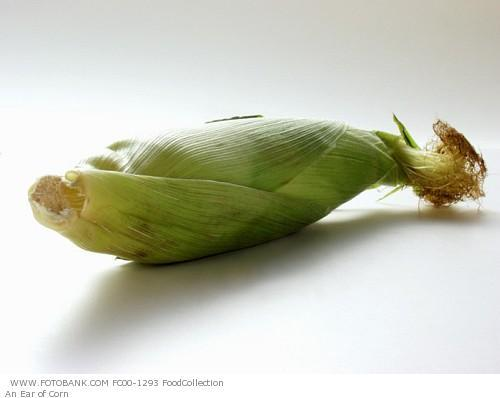

In [73]:
display(next(iter(shuffled_dataset))["image"])

In [79]:
pad = np.zeros((10, 5, 3))

In [77]:
pad[:, :, 2] = 1.0

In [81]:
c1 = np.asarray([42, 50])
c2 = np.asarray([36, 54])

In [83]:
for idx, itm in enumerate(zip(c1, c2)):
    print(idx, itm)

0 (42, 36)
1 (50, 54)


## Check the Impelementation

The experimental version is returning some odd results. It's showing that the models are finding the exact labels up to a relatively high size of probe set, and for the one model that is missing it seems to miss in the exact same way each time. Can I recreate this?

The only difference is when using the one hot vectors instead of the labels, but this shouldn't be different if the labels are the same.

There is a suggestion that this is the fault of ImageNet-1k as the models are trained on it,

In [123]:
# Example config
params = {
    "models": [
        "facebook/deit-tiny-patch16-224",
        "facebook/deit-small-patch16-224",
        "facebook/deit-base-patch16-224",
        "microsoft/cvt-13",
        "google/vit-base-patch16-384",
    ],
    "dataset_name": "imagenet-1k",
    "dataset_split": "validation",
    "n_examples": 1024,
    "random_state": 42,
    "one_hot_labels": False,
    "model_features": False,
    "pixel_square": 224,
}
dataset = load_dataset(
    params["dataset_name"], split=params["dataset_split"], streaming=True, token=True
)
dataset = dataset.shuffle(seed=params["random_state"], buffer_size=1000)
params["dataset"] = dataset

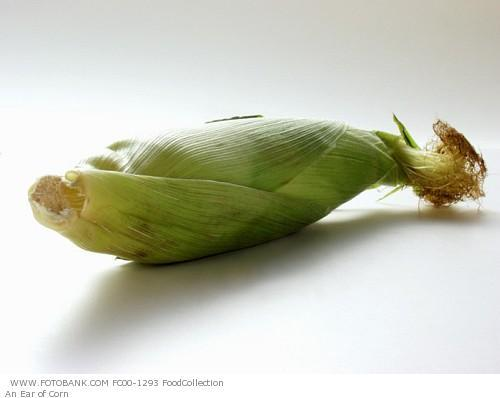

In [124]:
next(iter(params["dataset"]))["image"]

In [125]:
# Load TDA objects
cub_hom = hom.CubicalPersistence()
per_img = dgms.PersistenceImage()

In [126]:
# Process the data for TDA:
from locomoset.metrics.tda import tda_preprocess

tda_imgs = params["dataset"].map(
    tda_preprocess, remove_columns="image", batched=True, batch_size=1
)
tda_imgs = tda_imgs.with_format("torch")

In [127]:
next(iter(tda_imgs))

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


{'label': tensor(998),
 'pixel_values': tensor([[[0.8196, 0.8196, 0.8196,  ..., 0.7333, 0.7294, 0.7294],
          [0.8196, 0.8196, 0.8196,  ..., 0.7333, 0.7294, 0.7294],
          [0.8196, 0.8196, 0.8196,  ..., 0.7333, 0.7294, 0.7294],
          ...,
          [0.9725, 0.9765, 0.8980,  ..., 1.0000, 1.0000, 1.0000],
          [0.9804, 0.9686, 0.8471,  ..., 1.0000, 1.0000, 1.0000],
          [0.9686, 0.9725, 0.8863,  ..., 1.0000, 1.0000, 1.0000]]])}

In [128]:
# Creat probe set for ground truths
from locomoset.metrics.tda import ground_truth_label, one_tda_example

labels = ground_truth_label(params["n_examples"], tda_imgs, params["one_hot_labels"])
labels

array([998., 284., 437., 821., 546., 488., 138., 933., 237., 875., 534., 804., 377., 920., 342., 451., 211., 966., 942., 417., 996., 252., 126.,  33., 338., 875., 833.,   3.,
       932.,  68., ..., 666., 787., 385., 333., 561., 156., 117.,  59., 482., 853., 308.,   3., 953., 246., 204., 739., 108., 314., 812., 209., 765., 593., 754., 930., 421., 360.,
       904., 637., 465.,  55.])

In [129]:
examples = []
for idx, image in enumerate(tda_imgs):
    examples.append(
        one_tda_example(image["pixel_values"], labels[idx], params["one_hot_labels"])
    )
    if idx == params["n_examples"] - 1:
        break
examples[0][-1][-1]

array([998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998.,
       998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998.,
       998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998.,
       998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998.,
       998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998.,
       998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998., 998.

In [130]:
ground_truth_probe_set = np.concatenate(examples, axis=0)
ground_truth_probe_set.shape

(1024, 225, 224)

In [131]:
# create model probe set
from locomoset.metrics.tda import preprocess

model_fn = AutoModelForImageClassification.from_pretrained(params["models"][0])
processor = AutoImageProcessor.from_pretrained(params["models"][0])
fn_kwargs = {"processor": processor}
imgs = params["dataset"].map(
    preprocess, remove_columns="image", batched=True, batch_size=1, fn_kwargs=fn_kwargs
)
imgs = imgs.with_format("torch")

In [132]:
preds = np.zeros(params["n_examples"])
for idx, image in enumerate(imgs):
    preds[idx] = model_fn(image["pixel_values"][None, :, :, :]).logits.argmax(-1).item()
    if idx == params["n_examples"] - 1:
        break
preds

array([944., 284., 437., 821., 546., 474., 138., 933., 236., 875., 534., 804., 379., 920., 133., 584., 211., 621., 942., 417., 996., 252., 126., 642., 333., 486., 833., 147.,
       932., 111., ..., 666., 856., 385., 333., 561., 156., 619.,  58., 848., 853., 308.,   3., 953., 176., 204., 739., 108., 312., 812., 209., 765., 593., 754., 930., 729., 360.,
       904., 448., 413.,  59.])

In [142]:
# Check differences between preds and labels, using the hamming weight of a difference
# vector
vecs = np.array(preds == labels) * 1
vecs = np.abs(vecs - 1)
np.sum(vecs)

341

so the model fails in 341 places.

Ok, so these definitely aren't the same, so what's going on? Do I need to create a new cub_hom for the diagrams each time?

In [143]:
# Same cub_hom instance:
gtruth_diags = cub_hom.fit_transform(ground_truth_probe_set)

In [144]:
print(gtruth_diags.shape)

# make a copy of it just to be sure
from copy import copy

gtruth_diags_copy = copy(gtruth_diags)

(1024, 13649, 3)


In [145]:
model_probe_set = []
for idx, image in enumerate(tda_imgs):
    model_probe_set.append(
        one_tda_example(
            image["pixel_values"],
            preds[idx],
        )
    )
    if idx == params["n_examples"] - 1:
        break
model_probe_set = np.concatenate(model_probe_set, axis=0)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


In [146]:
print(model_probe_set.shape)
model_probe_set[0][-1]

(1024, 225, 224)


array([944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944.,
       944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944.,
       944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944.,
       944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944.,
       944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944.,
       944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944., 944.

In [147]:
mdiags = cub_hom.fit_transform(model_probe_set)

In [148]:
print(mdiags.shape)

(1024, 13649, 3)


In [149]:
# Are they different?
np.linalg.norm(mdiags - gtruth_diags_copy)

15.279885581976258

Ok so this is different, but why....?

In [190]:
vec = mdiags == gtruth_diags
vec = np.sum(vec, axis=2) / 3
vec = np.sum(vec, axis=1)
new_vec = (vec == 13649.0) * 1.0
np.where(new_vec == 0)

(array([265]),)

In [193]:
np.linalg.norm(mdiags[265] - gtruth_diags[265])

15.279885581976258

so it varies in one diagram...?

In [197]:
print(labels[265])
print(preds[265])

391.0
0.0


In [201]:
np.where(preds == 0.0)

(array([238, 265]),)

In [204]:
labels[238]

0.0

ok, so, it only varies when there is a difference in the predicted labels vs. the ground truth labels and one of the two (but not both) is the label 0!

In [200]:
mdiags[238] - gtruth_diags[238]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
 

try it with some fake labels to see what the difference is

In [118]:
fake_labels = np.full(128, 69)

In [120]:
fake_probe_set = []
for idx, image in enumerate(tda_imgs):
    fake_probe_set.append(
        one_tda_example(
            image["pixel_values"],
            fake_labels[idx],
        )
    )
    if idx == params["n_examples"] - 1:
        break
fake_probe_set = np.concatenate(fake_probe_set, axis=0)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


In [121]:
fake_diags = cub_hom.fit_transform(fake_probe_set)

In [122]:
# is this different?
np.linalg.norm(fake_diags - gtruth_diags_copy)

0.0

ok, cool, so that's why it doesn't work. Well, for the most part, but that doesn't explain why one of them is different?

## Trying this with a different dataset

Lets try the pipeline with a different data set for now, oxfordpets

In [3]:
dataset = load_dataset("pcuenq/oxford-pets", split="train", streaming=True, token=True)

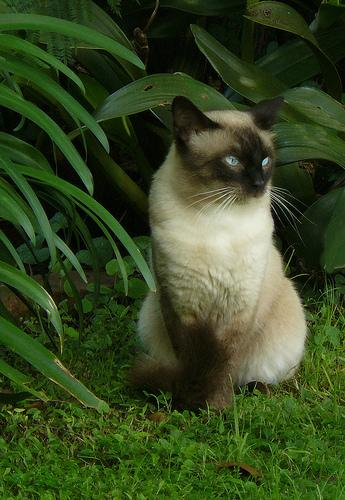

In [4]:
next(iter(dataset))["image"]

In [5]:
# Example config
params = {
    "models": [
        "facebook/deit-tiny-patch16-224",
        "facebook/deit-small-patch16-224",
        "facebook/deit-base-patch16-224",
        "microsoft/cvt-13",
        "google/vit-base-patch16-384",
    ],
    "dataset_name": "pcuenq/oxford-pets",
    "dataset_split": "train",
    "n_examples": 128,
    "random_state": 42,
    "one_hot_labels": True,
    "model_features": False,
    "pixel_square": 224,
}
dataset = load_dataset(
    params["dataset_name"], split=params["dataset_split"], streaming=True, token=True
)
dataset = dataset.shuffle(seed=params["random_state"], buffer_size=1000)
params["dataset"] = dataset

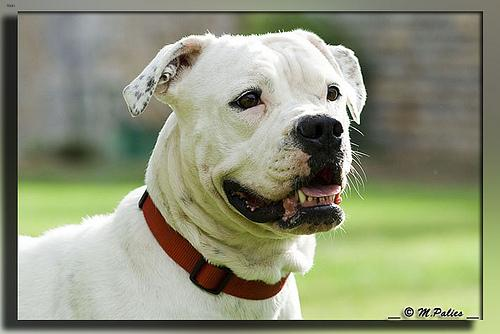

In [6]:
next(iter(params["dataset"]))["image"]

In [7]:
next(iter(params["dataset"]))

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/american_bulldog_66.jpg',
 'label': 'american bulldog',
 'dog': True,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x334>}

In [8]:
# Load TDA objects
cub_hom = hom.CubicalPersistence()
per_img = dgms.PersistenceImage()

In [9]:
# Process the data for TDA:
from locomoset.metrics.tda import tda_preprocess

tda_imgs = params["dataset"].map(
    tda_preprocess, remove_columns="image", batched=True, batch_size=1
)
tda_imgs = tda_imgs.with_format("torch")

In [10]:
next(iter(tda_imgs))

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/american_bulldog_66.jpg',
 'label': 'american bulldog',
 'dog': tensor(True),
 'pixel_values': tensor([[[0.5216, 0.5373, 0.5373,  ..., 0.4706, 0.4706, 0.4706],
          [0.5333, 0.5294, 0.5294,  ..., 0.4706, 0.4706, 0.4706],
          [0.5333, 0.5333, 0.5333,  ..., 0.4706, 0.4667, 0.4667],
          ...,
          [0.7098, 0.6157, 0.5373,  ..., 0.8078, 0.8078, 0.8078],
          [0.7451, 0.6941, 0.6510,  ..., 0.8118, 0.8118, 0.8118],
          [0.7725, 0.7490, 0.7216,  ..., 0.8157, 0.8157, 0.8157]]])}

In [11]:
# Creat probe set for ground truths
from locomoset.metrics.tda import one_tda_example

labels = []
for idx, label in enumerate(tda_imgs):
    labels.append(label["label"])
    if idx == params["n_examples"] - 1:
        break

In [12]:
labels = OneHotEncoder(sparse_output=False).fit_transform(
    np.asarray(labels).reshape(-1, 1)
)

In [13]:
labels.shape

(128, 37)

In [14]:
examples = []
for idx, image in enumerate(tda_imgs):
    examples.append(
        one_tda_example(image["pixel_values"], labels[idx], params["one_hot_labels"])
    )
    if idx == params["n_examples"] - 1:
        break

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


In [16]:
gtruth_probe_set = np.concatenate(examples, axis=0)

In [17]:
gtruth_probe_set.shape

(128, 225, 224)

In [20]:
gtruth_probe_set[0][-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
gtruth_diags = cub_hom.fit_transform(gtruth_probe_set)

In [22]:
gtruth_diags.shape

(128, 8717, 3)

Ok so we can get a the ground truth topolgy diagrams. But what about with the models? They don't have classifier head for the new models? We can use the features, but that didn't seem to work previously, might just have to run a bigger experiment to see if that works at all.

In [29]:
model_fn = AutoModelForImageClassification.from_pretrained(params["models"][-1])
processor = AutoImageProcessor.from_pretrained(params["models"][-1])

In [27]:
from locomoset.metrics.tda import preprocess

fn_kwargs = {"processor": processor}
imgs = params["dataset"].map(
    preprocess, remove_columns="image", batched=True, batch_size=1, fn_kwargs=fn_kwargs
)
imgs = imgs.with_format("torch")

What does this look like if we just use it as is? What kind of labels do we get?

In [31]:
preds = []
for idx, image in enumerate(imgs):
    preds.append(
        model_fn(image["pixel_values"][None, :, :, :]).logits.argmax(-1).item()
    )
    if idx == 4:
        break
preds

[242, 180, 200, 212, 242]

Ok, so what about if we replace the classifier head with a completely untrained one for oxford pets? Looks like I need to load a new one with the right number of classes.

In [33]:
# Can I just load it with the requisite num_labels?
model_fn = AutoModelForImageClassification.from_pretrained(
    params["models"][-1], num_labels=37, ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
preds = []
for idx, image in enumerate(imgs):
    preds.append(
        model_fn(image["pixel_values"][None, :, :, :]).logits.argmax(-1).item()
    )
    if idx == 4:
        break

Well it gives me reasonable looking labels I suppose? Lets try it for a reasonable size

In [37]:
preds = []
for idx, image in enumerate(imgs):
    preds.append(
        model_fn(image["pixel_values"][None, :, :, :]).logits.argmax(-1).item()
    )
    if idx == params["n_examples"] - 1:
        break

In [38]:
preds = OneHotEncoder(sparse_output=False).fit_transform(
    np.asarray(preds).reshape(-1, 1)
)

In [39]:
preds.shape

(128, 31)

In [40]:
examples = []
for idx, image in enumerate(tda_imgs):
    examples.append(
        one_tda_example(image["pixel_values"], preds[idx], params["one_hot_labels"])
    )
    if idx == params["n_examples"] - 1:
        break

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


In [41]:
model_probe_set = np.concatenate(examples, axis=0)

In [42]:
model_probe_set.shape

(128, 225, 224)

In [43]:
mdiags = cub_hom.fit_transform(model_probe_set)

In [44]:
mdiags.shape

(128, 8716, 3)

In [45]:
# Diagrams mismatch so merge with padding
from locomoset.metrics.tda import merge_diags

all_diags = merge_diags(gtruth_diags, mdiags)

In [47]:
all_diags.shape

(256, 8717, 3)

In [48]:
# create persistence image
pimg = per_img.fit_transform(all_diags)

In [49]:
pimg.shape

(256, 2, 100, 100)

In [50]:
# distance within topological complexity space
np.linalg.norm(pimg[:128, :, :, :] - pimg[128:, :, :, :])

2090.3957235770363

Ok this returns a roughly reasonable figure, what about if we do this for all the models?

In [52]:
def create_model_diags(tda_img_iter, cub_homology, **pars):
    model_diags = []
    for model in pars["models"]:
        model_fn = AutoModelForImageClassification.from_pretrained(
            model, num_labels=37, ignore_mismatched_sizes=True
        )
        processor = AutoImageProcessor.from_pretrained(model)
        fn_kwargs = {"processor": processor}
        imgs = pars["dataset"].map(
            preprocess,
            remove_columns="image",
            batched=True,
            batch_size=1,
            fn_kwargs=fn_kwargs,
        )
        imgs = imgs.with_format("torch")

        preds = []
        for idx, image in enumerate(imgs):
            preds.append(
                model_fn(image["pixel_values"][None, :, :, :]).logits.argmax(-1).item()
            )
            if idx == pars["n_examples"] - 1:
                break
        preds = OneHotEncoder(sparse_output=False).fit_transform(
            np.asarray(preds).reshape(-1, 1)
        )

        examples = []
        for idx, image in enumerate(tda_img_iter):
            examples.append(
                one_tda_example(
                    image["pixel_values"], preds[idx], pars["one_hot_labels"]
                )
            )
            if idx == pars["n_examples"] - 1:
                break
        model_probe_set = np.concatenate(examples, axis=0)
        model_diags.append(cub_homology.fit_transform(model_probe_set))

    return model_diags

In [53]:
mdiags = create_model_diags(tda_imgs, cub_hom, **params)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([37, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
Some weights of ViTForImageClassific

In [54]:
all_diags = gtruth_diags
for diag in mdiags:
    all_diags = merge_diags(all_diags, diag)

In [55]:
pimg = per_img.fit_transform(all_diags)

In [56]:
base_img = pimg[:128, :, :, :]
for idx, itm in enumerate(params["models"]):
    idx1 = params["n_examples"] * (idx + 1)
    idx2 = params["n_examples"] * (idx + 2)
    model_img = pimg[idx1:idx2, :, :, :]
    dist = np.linalg.norm(base_img - model_img)
    print(f"the topological complexity comparison for {itm} is {dist}")

the topological complexity comparison for facebook/deit-tiny-patch16-224 is 1908.4329936685124
the topological complexity comparison for facebook/deit-small-patch16-224 is 1802.4623549951714
the topological complexity comparison for facebook/deit-base-patch16-224 is 1846.0187355342373
the topological complexity comparison for microsoft/cvt-13 is 1904.402620079719
the topological complexity comparison for google/vit-base-patch16-384 is 2026.7117301685785


but I have no idea if this makes any sort of sense....

Essentially we've got a set of features, and then we've got a map from these features to the classifier, but this also needs to be trained to be accurate. I just don't think this is going to work without some training.